# Dimension reduction

## Outline

1. Problem statement
1. Random Projections
1. PCA
1. Truncated SVD
1. NMF
1. Manifold learning
1. TSNE
1. Autoencoders
1. Denoising Autoencoders
1. Sparse Autoencoders

## 1 Problem Statement


Given a set of points $X \in R^{NxD}$, find a map into a lower dimension subspace $f: R^D \rightarrow R^d$ $d  << D$

Depending of the map function there are:  

1. Linear methods: PCA, SVD, NMF, etc..
1. Nonlinear methods

Sometimes, feature selection is considered as dimension reduction.

# 2 Random Projections

<img src="images/proj.png" style="height:300px">

$$ f(X) = X S $$
where $ S \in R^d$

A common example is a gaussian random projection:
1. S is sampled from a normal gaussian distribution
1. each row has unit norm $ ||S_{i,:} || = 1$
1. rows are pairwise orthogonal $ S_{i,:}^T S_{j,:} = 0 $ iff $i \neq j$



Johnson - Lindenstrauss Lemma:   
States, that a set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved.  

Given $0 < \epsilon  < 1$, a set of points $X \in R^D$, number $d > \frac {8 \log(m)} {\epsilon^2}$, there exists a linear map $f: R^D \rightarrow R^d$ such that:  
$$ (1-\epsilon) ||u - v||^2 \leq ||f(u) - f(v)||^2 \leq (1+\epsilon) ||u - v||^2$$

There exists a set of points of size $m$ that needs dimension  
$O ( \frac {\log(m)} {\epsilon^2} )$ in order to preserve the distances between all pair of points.

# 3 PCA

Preserve more information while reducing feature dimensions. Here we make assumption that we measure quantity of information by variance. More variable the feature is, more information it contains.

Learning objective:
$$ ||X U - \hat X_k U_k||_F \rightarrow \min_{U}$$, where  $rank(\hat X_k) = k$ and $U_k$ contains first k column vectors of $U$. 


General scheme for PCA:

1. center data $\bar X = X - mean(X)$  
1. build covariance matrix $cov = \bar X \bar X^T$  
1. make low-rank approximation for covariance matrix $X \approx \hat X_k = U_k \Sigma_k U_k^T$ by eigendecomposition
1. sort eigenvalues in descending order by their absolute value
1. select top-k eigenvalues and project data onto corresponding eigenvectors

Learned mapping:
$$f(X) = X U_k$$


Properties:
1. PCA basis vectors creates an uncorrelated orthogonal basis set.  
1. PCA is sensitive to feature scaling
1. variance explained ratio of  j-th principal component = $\frac {|\Sigma_jj|} / {trace(|S|)} $  

<img src="images/pca.png" style="height:300px">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

%matplotlib inline

SEED = 42
np.random.seed(SEED)

In [62]:
data = datasets.fetch_olivetti_faces()

In [63]:
X = data['data']
y = data['target']

In [64]:
X.shape, y.shape, np.unique(y).shape

((400, 4096), (400,), (40,))

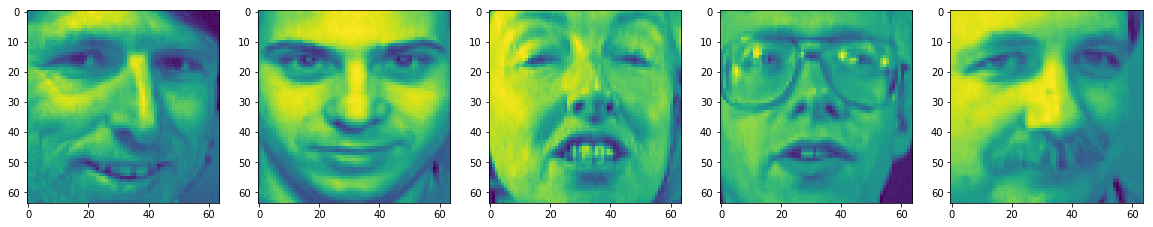

In [78]:
f, ax = plt.subplots(1,5, figsize=(20,10))
for i in range(5):
    ax[i].imshow(X[np.random.choice(len(X))].reshape(64,64))

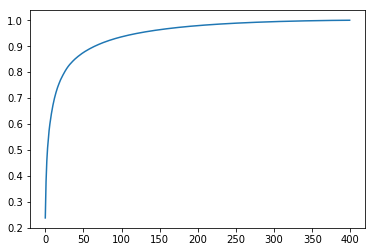

In [66]:
from sklearn.decomposition import PCA


pca = PCA(random_state=SEED, whiten=True).fit(X)

xx = pca.explained_variance_ratio_
xx = np.cumsum(xx)

plt.plot(np.arange(len(xx)), xx)

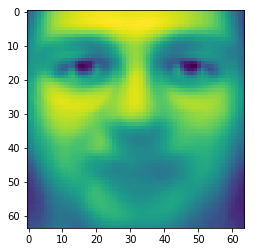

In [67]:
# eigenfaces

plt.imshow(pca.mean_.reshape(64,64))

<Figure size 432x288 with 0 Axes>

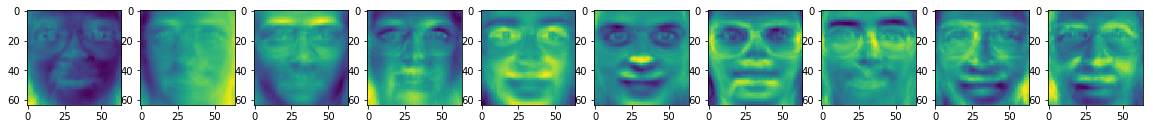

In [80]:
plt.figure(5)
f, ax = plt.subplots(1,10, figsize=(20,20))
for i in range(10):
    ax[i].imshow(pca.components_[i].reshape(64,64))

# 4 Truncated SVD

Learning objective:  
$$ || X - \hat X_k||_F \rightarrow min$$
subject to $rank(X_k) = k$.  

which has the exact solution given by SVD decomposition
$$ X \approx \hat X_k = U_k \Sigma_k V^T$$

Learned mapping:  
$ \hat X = X V_k$

Properties:
1. Do not use covariance matrix
1. Do not center data
1. Preferable over PCA for sparse features

<img src="images/svd.png" style="height:300px">

# 5 NMF 

Learnable objective:

$$ || X - WH ||_F \rightarrow \min_{W, H}$$
subject to $X >= 0$, $W >= 0$ and $H >=0 0$.

$$ X \approx \hat X_k = W H $$

Regularized with ElasticNet:  
$ || X - WH ||_F + \gamma *( \alpha(||W||_1 + ||H||_1)  + \frac {1 - \alpha} 2 ( ||W||_2  + ||H||_2)) \rightarrow \min_{W, H} $

Properties:
1. use for tf-idf features
1. more interpretable solution (topic modeling)

<img src="images/nmf.jpg" style="height:400px">

# 6 Manifold learning

Data lies on a low-dimensional non-linear manifold in a high-dimensional space. In other words, features are connected by some non-linear function.


<img src="images/manifold1.png" style="height:300px">

<img src="images/manifold2.png" style="height:300px">

# 7 TSNE

## t-distributed stochastic neighbor embedding


Algorithm:  
1. Compute probability that a sample $x_i$ would peak $x_j$ as its neighbour  
$$ p(j | i) = \frac {1} {Z} \exp (- || x_i - x_j||^2 / 2 \sigma_i^2) $$  
$Z = \sum_{k \neq i} \exp (- || x_i - x_k||^2 / 2 \sigma_i^2) $ - normalization factor

2. probability that $x_i$ and $x_j$ are neighbors:  
$$ p(i,j) = \frac {p(i | j)  + p(j | i)} 2$$  
but $p(i,i) = 0$

3. introduce map $Y \in R^d$, for wich probabolity that $y_i$ and $y_j$ are neighbors:   
$$ q(i, j) = \frac 1 Z (1 + || y_i - y_j||^2 )^{-1}$$
$Z = \sum_{k \neq i} (1 + || y_i - y_k||^2 )^{-1} $ - normalization factor

4. Learning objective = minimize Kullback–Leibler divergence (distance between distributions):
$$ KL(P || Q) = \sum_{i \neq j} p(i,j) \log \frac {p(i,j)} {q(i,j)} \rightarrow \min_{Y} $$


In [116]:
from sklearn.manifold import TSNE
from sklearn import metrics
from scipy import sparse
from sklearn.feature_extraction.text import TfidfTransformer

import matplotlib as mpl
from ipywidgets import interact, IntSlider, FloatSlider

In [138]:
data = datasets.fetch_20newsgroups_vectorized()

In [139]:
X = data['data']
y = data['target']

In [140]:
X = TfidfTransformer().fit_transform(X)

In [141]:
X.shape, y.shape

((11314, 130107), (11314,))

In [142]:
X = sparse.vstack([X[np.where(y == i)[0][:200]] for i in range(3)])
y = np.concatenate([y[np.where(y == i)[0][:200]] for i in range(3)])

In [143]:
X.shape, y.shape

((600, 130107), (600,))

In [144]:
dist = metrics.pairwise_distances(X, metric='cosine')
dist.shape

(600, 600)

In [149]:
perplexity_slider = FloatSlider(min=1, max=50, step=5, value=30)
learning_rate_slider = FloatSlider(min=1, max=1000, step=10, value=200)
early_exaggeration_slider = FloatSlider(min=10, max=20, step=1.0, value=12.0)


@interact(
    perplexity=perplexity_slider, 
    learning_rate=learning_rate_slider,
    early_exaggeration=early_exaggeration_slider
)


def plot(perplexity, learning_rate, early_exaggeration):
    
    model = TSNE(n_components=2, 
                 perplexity=perplexity,
                 learning_rate=learning_rate,
                 early_exaggeration=early_exaggeration,
                 metric='precomputed'
                )
    
    xx = model.fit_transform(dist)
    
    plt.figure(figsize=(10,10))
    for label in range(len(np.unique(y))):
        plt.scatter(xx[y == label,0], xx[y  == label, 1], label = data['target_names'][label], alpha=0.5)
    
    plt.legend()

interactive(children=(FloatSlider(value=30.0, description='perplexity', max=50.0, min=1.0, step=5.0), FloatSli…

# 8 Autoencoders

Autoencoders are feed-forward neural networks, which contains encoder and decoder part. All training methods applicable to feed-forward NN, also can be applied to autoencoders. But unlike feed-forward NN, autoencoders are unsipervised models.

Let $E$ be encoder, $D$ - decoder, $L$  - some loss function.

Than, in the most simple case, the goal is to learn an efficient feature represetation by directing information through a bottleneck and predicting sample itself: 
$$ L(X, D(E(X))) \rightarrow \min_{D, E}$$

<img src="images/autoencoder.png" style="height:300px">

In [262]:
import torch as tt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

tt.manual_seed(SEED)

In [278]:
data = datasets.fetch_olivetti_faces()

In [279]:
X = data['data']
y = data['target']

X.shape

(400, 4096)

In [280]:
train_loader = DataLoader(X, batch_size=64, shuffle=True)

In [281]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(64*64, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, 12),
            nn.ELU(),
            nn.Linear(12, 3),   # compress to 3 features which can be visualized in plt
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ELU(),
            nn.Linear(12, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, 64*64),
            nn.Sigmoid(),       # compress to a range (0, 1)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [287]:
autoencoder = AutoEncoder()

optimizer = optim.Adam(autoencoder.parameters(), lr=0.001, betas=(0.8,0.99))
loss_func = nn.MSELoss()

n_epochs = 100

In [288]:
# initialize figure

N_TEST_IMG = 3
view_data = tt.FloatTensor(X[np.random.choice(len(X), N_TEST_IMG)])

def plot_data(decoded_data, n_samples=N_TEST_IMG):
    f, ax = plt.subplots(1, n_samples, figsize=(7, 7))
    
    for i in range(N_TEST_IMG):
        ax[i].imshow(np.reshape(decoded_data.data.numpy()[i], (64, 64)), cmap='gray')
        ax[i].set_xticks(())
        ax[i].set_yticks(())
        
    plt.show()

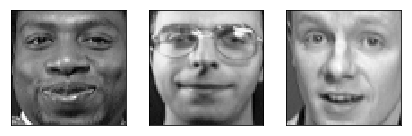

In [289]:
plot_data(view_data)

Epoch:  0 | train loss: 0.0320


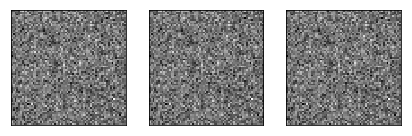

Epoch:  1 | train loss: 0.0296


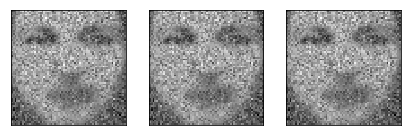

Epoch:  2 | train loss: 0.0206


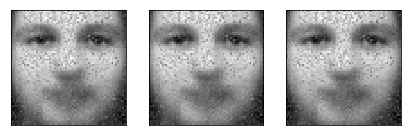

Epoch:  3 | train loss: 0.0177


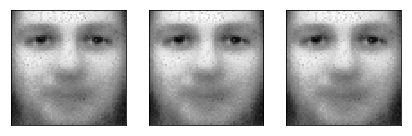

Epoch:  4 | train loss: 0.0181


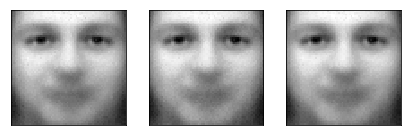

Epoch:  5 | train loss: 0.0172


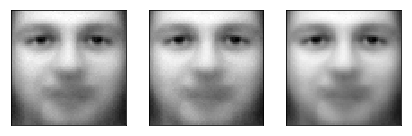

Epoch:  6 | train loss: 0.0198


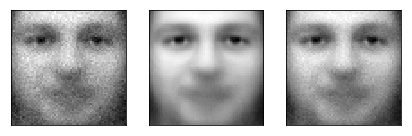

Epoch:  7 | train loss: 0.0181


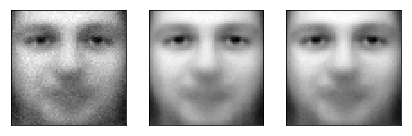

Epoch:  8 | train loss: 0.0178


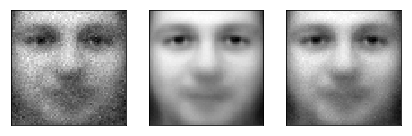

Epoch:  9 | train loss: 0.0160


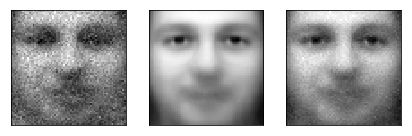

Epoch:  10 | train loss: 0.0162


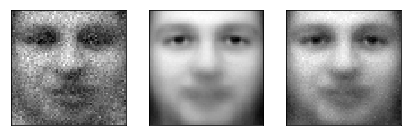

Epoch:  11 | train loss: 0.0157


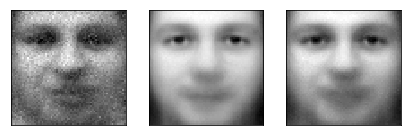

Epoch:  12 | train loss: 0.0143


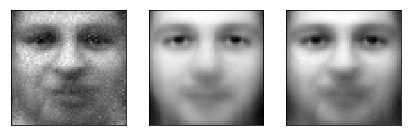

Epoch:  13 | train loss: 0.0160


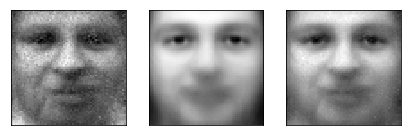

Epoch:  14 | train loss: 0.0153


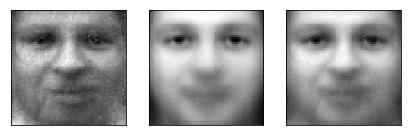

Epoch:  15 | train loss: 0.0139


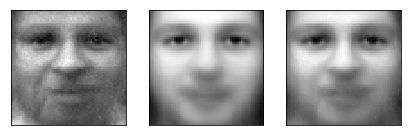

Epoch:  16 | train loss: 0.0168


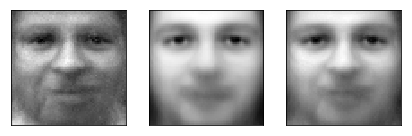

Epoch:  17 | train loss: 0.0144


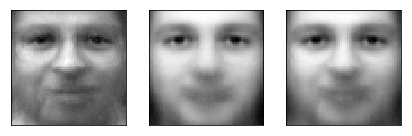

Epoch:  18 | train loss: 0.0153


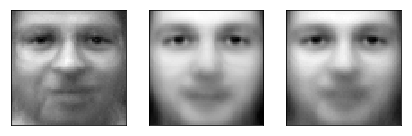

Epoch:  19 | train loss: 0.0162


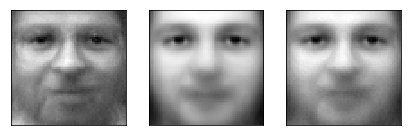

Epoch:  20 | train loss: 0.0144


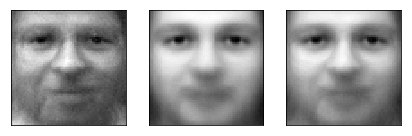

Epoch:  21 | train loss: 0.0148


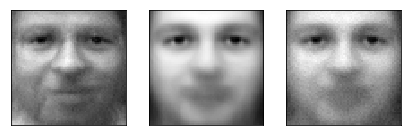

Epoch:  22 | train loss: 0.0148


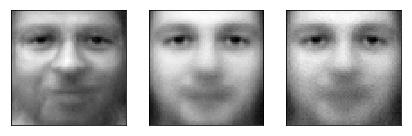

Epoch:  23 | train loss: 0.0137


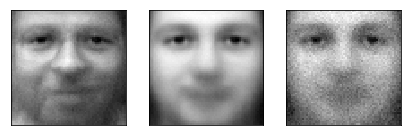

Epoch:  24 | train loss: 0.0139


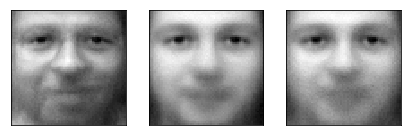

Epoch:  25 | train loss: 0.0134


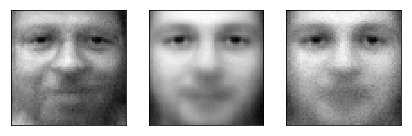

Epoch:  26 | train loss: 0.0143


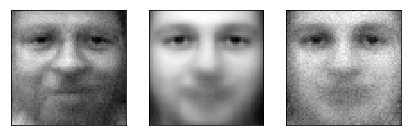

Epoch:  27 | train loss: 0.0125


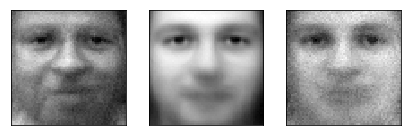

Epoch:  28 | train loss: 0.0129


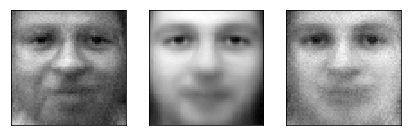

Epoch:  29 | train loss: 0.0125


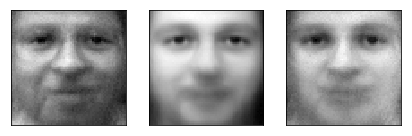

Epoch:  30 | train loss: 0.0125


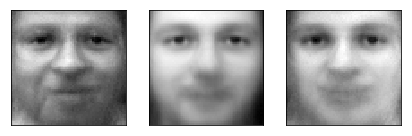

Epoch:  31 | train loss: 0.0126


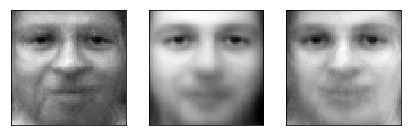

Epoch:  32 | train loss: 0.0133


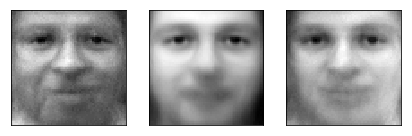

Epoch:  33 | train loss: 0.0135


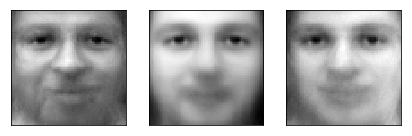

Epoch:  34 | train loss: 0.0115


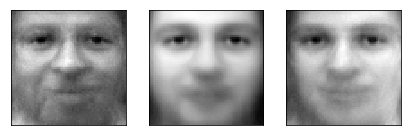

Epoch:  35 | train loss: 0.0129


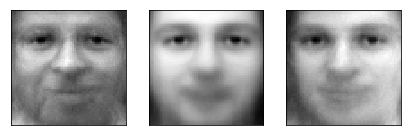

Epoch:  36 | train loss: 0.0125


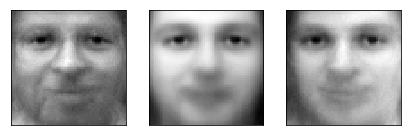

Epoch:  37 | train loss: 0.0124


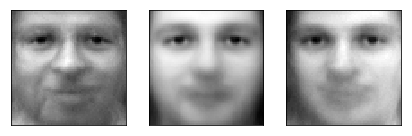

Epoch:  38 | train loss: 0.0123


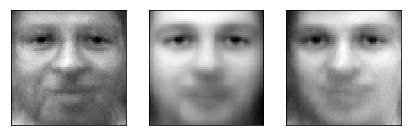

Epoch:  39 | train loss: 0.0119


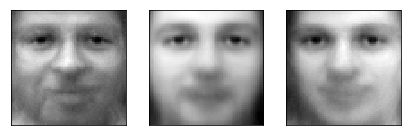

Epoch:  40 | train loss: 0.0121


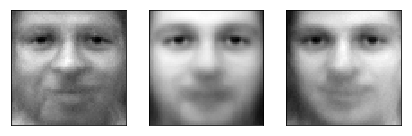

Epoch:  41 | train loss: 0.0116


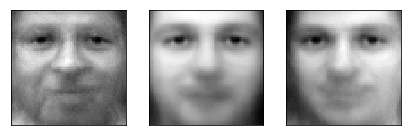

Epoch:  42 | train loss: 0.0121


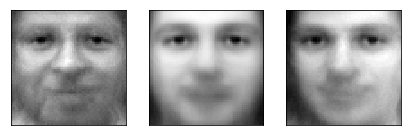

Epoch:  43 | train loss: 0.0124


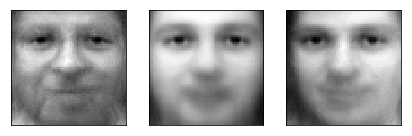

Epoch:  44 | train loss: 0.0124


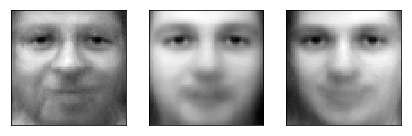

Epoch:  45 | train loss: 0.0114


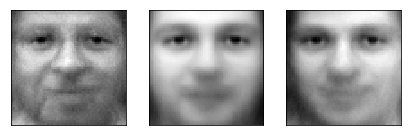

Epoch:  46 | train loss: 0.0116


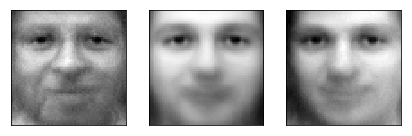

Epoch:  47 | train loss: 0.0123


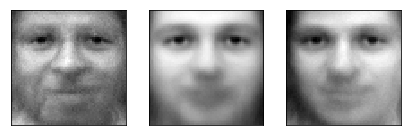

Epoch:  48 | train loss: 0.0120


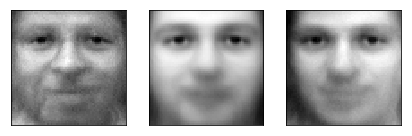

Epoch:  49 | train loss: 0.0113


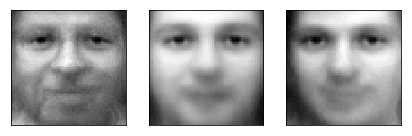

Epoch:  50 | train loss: 0.0122


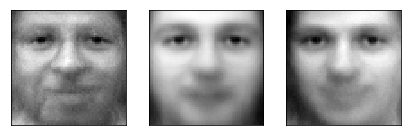

Epoch:  51 | train loss: 0.0116


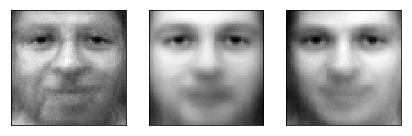

Epoch:  52 | train loss: 0.0116


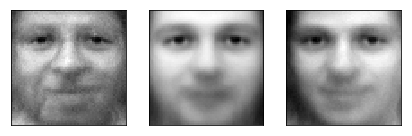

Epoch:  53 | train loss: 0.0114


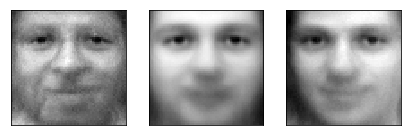

Epoch:  54 | train loss: 0.0112


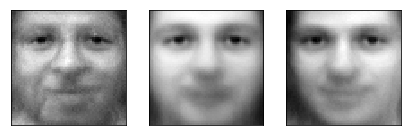

Epoch:  55 | train loss: 0.0117


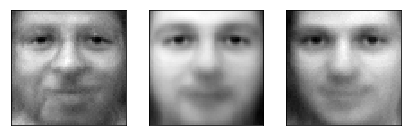

Epoch:  56 | train loss: 0.0116


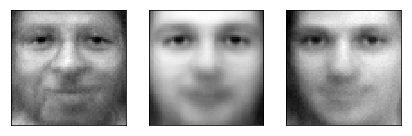

Epoch:  57 | train loss: 0.0116


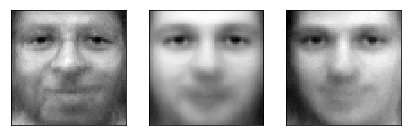

Epoch:  58 | train loss: 0.0109


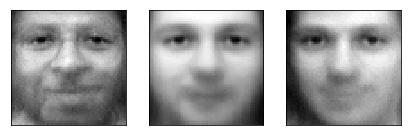

Epoch:  59 | train loss: 0.0118


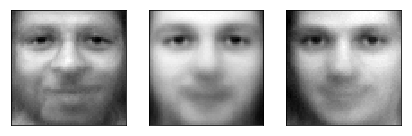

Epoch:  60 | train loss: 0.0101


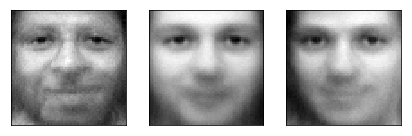

Epoch:  61 | train loss: 0.0103


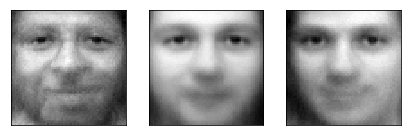

Epoch:  62 | train loss: 0.0108


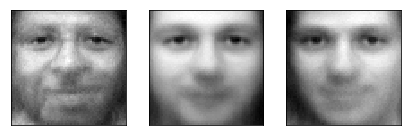

Epoch:  63 | train loss: 0.0109


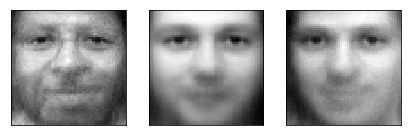

Epoch:  64 | train loss: 0.0105


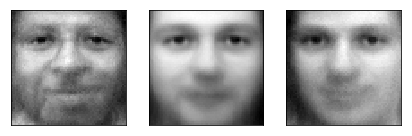

Epoch:  65 | train loss: 0.0099


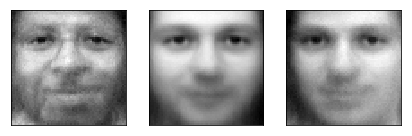

Epoch:  66 | train loss: 0.0103


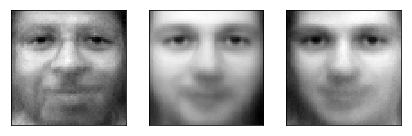

Epoch:  67 | train loss: 0.0102


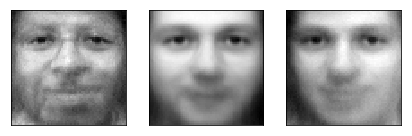

Epoch:  68 | train loss: 0.0104


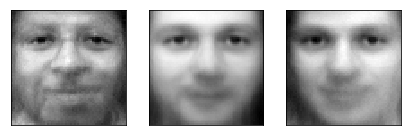

Epoch:  69 | train loss: 0.0109


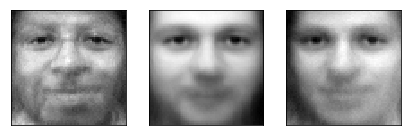

Epoch:  70 | train loss: 0.0100


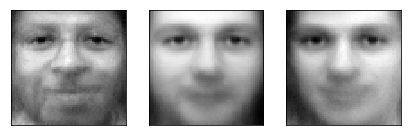

Epoch:  71 | train loss: 0.0097


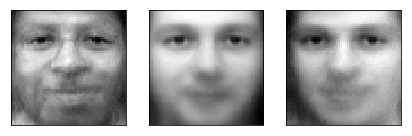

Epoch:  72 | train loss: 0.0099


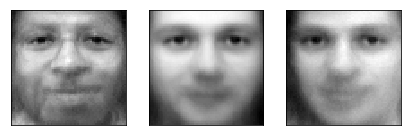

Epoch:  73 | train loss: 0.0095


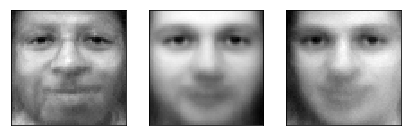

Epoch:  74 | train loss: 0.0110


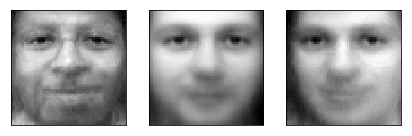

Epoch:  75 | train loss: 0.0103


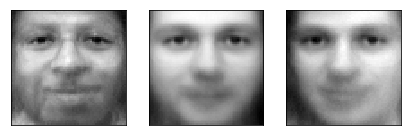

Epoch:  76 | train loss: 0.0101


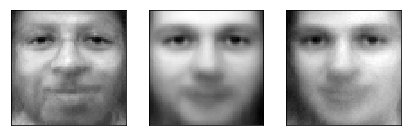

Epoch:  77 | train loss: 0.0099


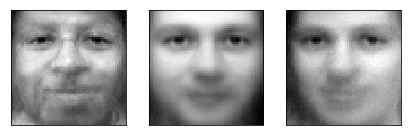

Epoch:  78 | train loss: 0.0099


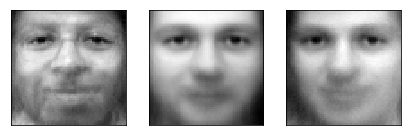

Epoch:  79 | train loss: 0.0108


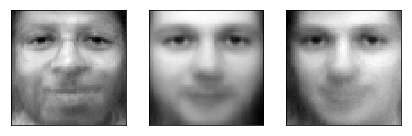

Epoch:  80 | train loss: 0.0102


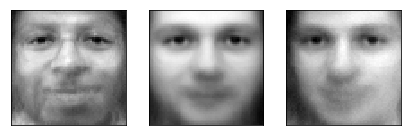

Epoch:  81 | train loss: 0.0093


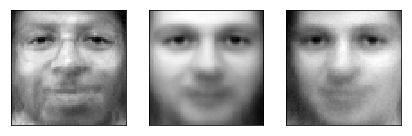

Epoch:  82 | train loss: 0.0110


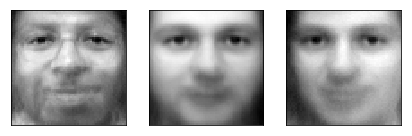

Epoch:  83 | train loss: 0.0098


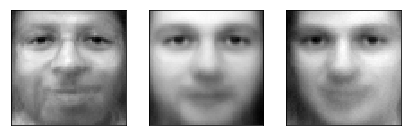

Epoch:  84 | train loss: 0.0104


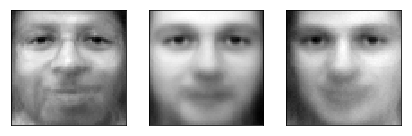

Epoch:  85 | train loss: 0.0097


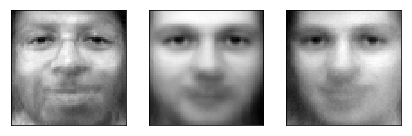

Epoch:  86 | train loss: 0.0101


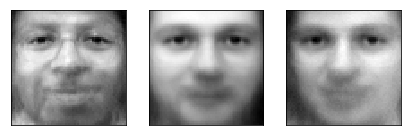

Epoch:  87 | train loss: 0.0101


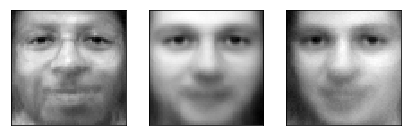

Epoch:  88 | train loss: 0.0102


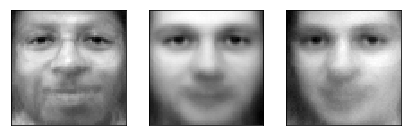

Epoch:  89 | train loss: 0.0105


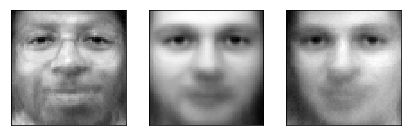

Epoch:  90 | train loss: 0.0102


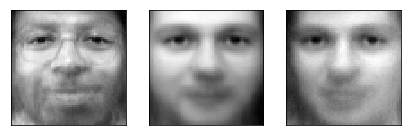

Epoch:  91 | train loss: 0.0097


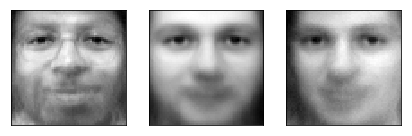

Epoch:  92 | train loss: 0.0102


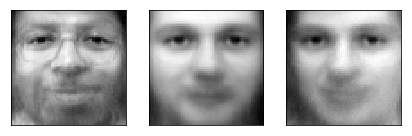

Epoch:  93 | train loss: 0.0097


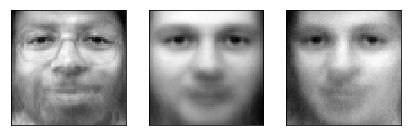

Epoch:  94 | train loss: 0.0108


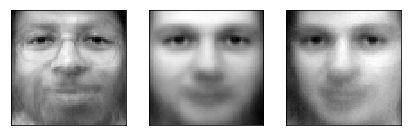

Epoch:  95 | train loss: 0.0096


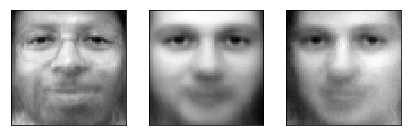

Epoch:  96 | train loss: 0.0100


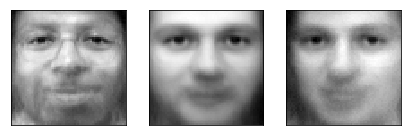

Epoch:  97 | train loss: 0.0104


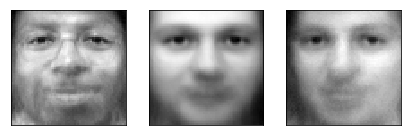

Epoch:  98 | train loss: 0.0101


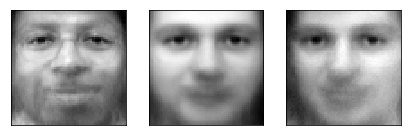

Epoch:  99 | train loss: 0.0095


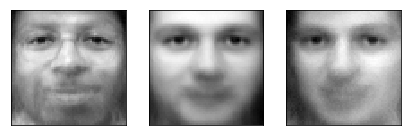

In [290]:
for epoch in range(n_epochs):
    for step, batch_x in enumerate(train_loader):

        encoded, decoded = autoencoder(batch_x)

        loss = loss_func(decoded, batch_x)      # mean square error
        optimizer.zero_grad()               # clear gradients for this training step
        loss.backward()                     # backpropagation, compute gradients
        optimizer.step()                    # apply gradients

        if step % 100 == 0:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.numpy())

            # plotting decoded image (second row)
            _, decoded_data = autoencoder(view_data)
            
            plot_data(decoded_data)

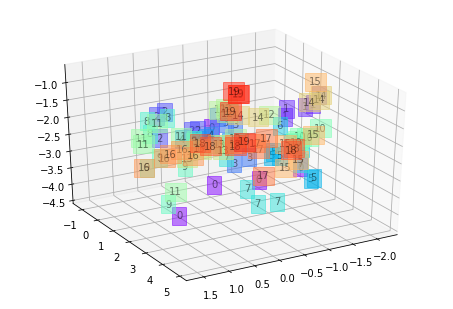

In [291]:
# visualize in 3D plot
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm


XX = np.vstack([data['data'][np.where(data['target'] == l)[0][:5]] for l in range(20)])
YY = np.concatenate([data['target'][np.where(data['target'] == l)[0][:5]] for l in range(20)])


view_data = tt.FloatTensor(XX)
encoded_data, _ = autoencoder(view_data)

fig = plt.figure(2)
ax = Axes3D(fig, azim=60, elev=30)
X, Y, Z = encoded_data.data[:, 0].numpy(), encoded_data.data[:, 1].numpy(), encoded_data.data[:, 2].numpy()

values = YY

for x, y, z, s in zip(X, Y, Z, values):
    c = cm.rainbow(int(255*s/20), alpha=0.5)
    ax.text(x, y, z, s, backgroundcolor=c, alpha=0.5)
#     ax.scatter(x,y,z, label=s)

    
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

# 9 Denoising autoencoders

Denoising autoencoders try to reconstruct a sample from a noisy one:

$$ \bar X = X + \epsilon $$,
usually we use white noise $\epsilon ~ N(0,1)$

Learning objective:
$$ L(X, D(E(\bar X))) \rightarrow \min_{D, E}$$

# 10 Sparse autoencoders

Sparse autoencoders use another definition of efficiency: good representation should be sparse, so particular sample phenotype will depend only on a small number of features (ideally, 1 feature). It can be achieved by imposing $L_1$ regularization on feature representation.

$$ Z = E(X)$$
$$ L(X, D(Z)) + \alpha ||Z||_1 \rightarrow \min_{D, E} $$

<img src="images/sparse.jpg" style="height:500px">


There are other autoencoder models not discussed here, e.g. variational autoencoders.